In [9]:
from utils import*

In [10]:
source_dir='./'

In [11]:
covid_features=sio.loadmat(os.path.join(source_dir,'covid.mat')) 
covid_features=covid_features['covid'] 

normal_features=sio.loadmat(os.path.join(source_dir,'normal.mat')) 
normal_features=normal_features['normal']  

pneumonia_features=sio.loadmat(os.path.join(source_dir,'pneumonia.mat')) 
pneumonia_features=pneumonia_features['pneumonia']  

In [12]:
X=np.concatenate((covid_features[:,:-1],normal_features[:,:-1],pneumonia_features[:,:-1]), axis=0)#inputs
y=np.concatenate((covid_features[:,-1],normal_features[:,-1],pneumonia_features[:,-1]), axis=0)#target labels

In [13]:
min_max_scaler=MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [14]:
transformer = KernelPCA(n_components=64, kernel='linear')
X = transformer.fit_transform(X)

In [15]:
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

In [21]:
model = build_model(feature_size=X.shape[-1], n_classes=y.shape[-1])
#show_model(model)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 51        
Total params: 10,435
Trainable params: 10,435
Non-trainable params: 0
__________________________________________________

Epoch 1/100
113/113 [==============================] - 0s 2ms/step - loss: 1.0962 - categorical_accuracy: 0.3156 - val_loss: 1.1000 - val_categorical_accuracy: 0.3026
Epoch 2/100
113/113 [==============================] - 0s 850us/step - loss: 1.0787 - categorical_accuracy: 0.3600 - val_loss: 1.0765 - val_categorical_accuracy: 0.3026
Epoch 3/100
113/113 [==============================] - 0s 832us/step - loss: 1.0248 - categorical_accuracy: 0.5289 - val_loss: 1.0174 - val_categorical_accuracy: 0.5921
Epoch 4/100
113/113 [==============================] - 0s 858us/step - loss: 0.9861 - categorical_accuracy: 0.5644 - val_loss: 0.9500 - val_categorical_accuracy: 0.6316
Epoch 5/100
113/113 [==============================] - 0s 876us/step - loss: 0.8978 - categorical_accuracy: 0.6844 - val_loss: 0.8735 - val_categorical_accuracy: 0.6842
Epoch 6/100
113/113 [==============================] - 0s 912us/step - loss: 0.8257 - categorical_accuracy: 0.7200 - val_loss: 0.7733 - val_categorical_accur

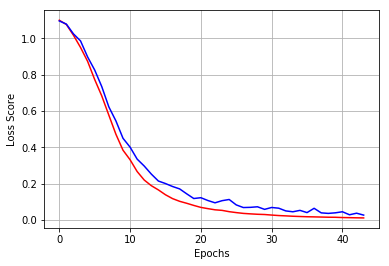

In [22]:
opt = tf.keras.optimizers.Adam(lr=0.001)
criterion = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=criterion,metrics=[keras.metrics.categorical_accuracy])
model_early_stopping=EarlyStopping(monitor='val_loss', min_delta=.005, patience=5, verbose=1)# early stopping settings
model.fit(X_train, y_train,batch_size = 2,epochs=100, validation_data = (X_val, y_val),callbacks=[model_early_stopping])

fig = plt.figure()
plt.plot(model.history.history['val_loss'], 'r', model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss Score')
plt.grid(1)
plt.savefig('training_loss.jpg',dpi=300)

[[30  0  0]
 [ 0 16  0]
 [ 0  0 30]]
Confusion matrix, without normalization
[[30  0  0]
 [ 0 16  0]
 [ 0  0 30]]
3/3 [==============================] - 0s 1ms/step - loss: 0.0094 - categorical_accuracy: 1.0000
[0.009423854760825634, 1.0]


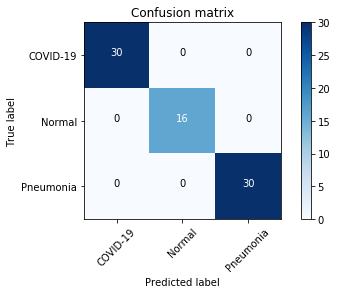

In [23]:
Y_Score=model.predict(X_test)
y_pred = np.argmax(Y_Score, axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1),y_pred)
print(cm)

fig = plt.figure()
plot_confusion_matrix(cm,classes=['COVID-19','Normal','Pneumonia'])
plt.savefig('conf_matrix.jpg',dpi=300)

test_loss=model.evaluate(X_test,y_test,verbose=1)#evaluate model
print(test_loss)#print test loss and metrics information

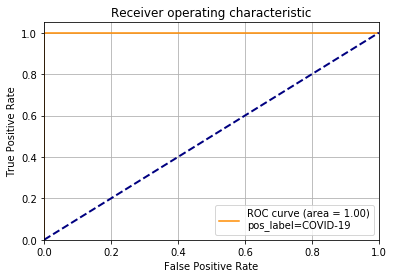

In [24]:
pos_label=0
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis=1), Y_Score[:,pos_label], pos_label=pos_label)
roc_auc = auc(fpr, tpr)# calculate auc value
fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)\npos_label=COVID-19' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.grid(1)
plt.legend(loc="lower right")
plt.savefig('roc_covid.jpg',dpi=300)

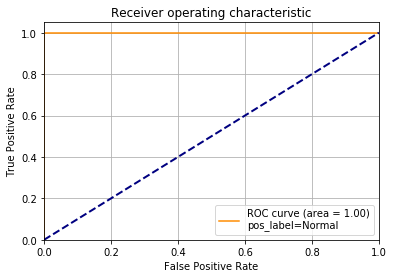

In [25]:
pos_label=1
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis=1), Y_Score[:,pos_label], pos_label=pos_label)
roc_auc = auc(fpr, tpr)# calculate auc value
fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)\npos_label=Normal' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.grid(1)
plt.legend(loc="lower right")
plt.savefig('roc_normal.jpg',dpi=300)

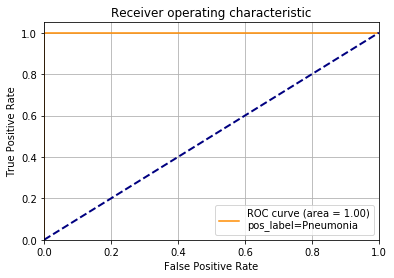

In [26]:
pos_label=2
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis=1), Y_Score[:,pos_label], pos_label=pos_label)
roc_auc = auc(fpr, tpr)# calculate auc value
fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)\npos_label=Pneumonia' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.grid(1)
plt.legend(loc="lower right")
plt.savefig('roc_pneumonia.jpg',dpi=300)